The code from tutorial week_6.ipynb and week_8.ipynb is used in this notebook, which is really useful for me to finish this coursework and understand the concept of the special network. 
<br>
<br>
Credit to the lecturers and TAs.

In [1]:
import os
import glob
import time
import esda
import random
import geopandas
import spaghetti
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from haversine import haversine
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans
from shapely.geometry import Point, LineString

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# Task C

In [2]:
leeds_graph = ox.graph_from_place("Leeds, United Kingdom", network_type='drive')

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [3]:
# Get the coordinates of the nodes in the graph
X = np.array([[node[1]['x'], node[1]['y']] for node in leeds_graph.nodes(data=True)])

# Fit a KMeans model with 10 clusters
kmeans = KMeans(n_clusters=10,n_init = "auto", random_state=0).fit(X)

# Get the cluster centers and get the nearest nodes to the cluster centers as seeds
seeds = ox.nearest_nodes(leeds_graph, kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], return_dist=False)
seeds

[248497499,
 1636581669,
 1955838372,
 1543142533,
 392123154,
 1560077,
 938518749,
 317688615,
 2423171140,
 381915141]

1. Select the initial set of 10 cell seed points. For this, you can use several criteria, such as being far away from frequent accident roads, being close to public transport, being evenly spread, etc. (explain your choice in the report).

In [4]:
# Black color representation
black_color = (0.0, 0.0, 0.0, 1.0)  # change 'k' to RGBs value tuple (0.0, 0.0, 0.0, 1.0) if ValueError

In [5]:
def nodes_nearest_seed(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells, cells_inverse

cells, node_seed_dict = nodes_nearest_seed(leeds_graph, seeds)

In [6]:
def get_seed_color(seeds):
    seed_colors = dict(zip(seeds, ox.plot.get_colors(len(seeds))))  # {seed: seed's mapped color}
    seed_colors['unreachable'] = black_color
    return seed_colors

seed_colors = get_seed_color(seeds)

In [7]:
def map_node_color_from_seed(graph, seeds, node_seed_dict, seed_colors):
    return {node: seed_colors[node_seed_dict[node]] for node in graph.nodes}

node_color_dict = map_node_color_from_seed(leeds_graph, seeds, node_seed_dict, seed_colors)

In [8]:
def map_edge_color_from_node(graph, seeds, node_seed_dict, node_colors, seed_colors):
    edge_colors = []
    for i, e in enumerate(graph.edges):
        color_pair = [node_colors[e[0]], node_colors[e[1]]]
        if black_color in color_pair:  # unreachable
            color_pair.remove(black_color)
            edge_colors.append(color_pair[0])
        elif color_pair[0] == color_pair[1]:
            edge_colors.append(color_pair[0])
        else:
            len_0 = nx.shortest_path_length(graph, node_seed_dict[e[0]], e[0], weight='length')
            len_1 = nx.shortest_path_length(graph, node_seed_dict[e[1]], e[1], weight='length')
            if len_0 <= len_1:  # or discuss on equality cases
                edge_colors.append(color_pair[0])
            else:
                edge_colors.append(color_pair[1])
    return edge_colors

edge_colors = map_edge_color_from_node(leeds_graph, seeds, node_seed_dict, node_color_dict, seed_colors)
node_colors = ['r' if node in seeds else 'None' for node in leeds_graph.nodes]

In [9]:
# Remove the unreachable cell
del cells['unreachable']

In [218]:
# Create graphs for each cell
cell_graphs = [leeds_graph.subgraph(cell) for cell in cells.values()]

In [424]:
def find_line_route(cell_graph):
    nodes = list(cell_graph.nodes)

    while True:
        seed = random.choice(nodes)
        # Find the shortest path from the seed to all other nodes
        shortest_paths = nx.single_source_dijkstra_path(cell_graph, seed, weight='length').values()
        shortest_path_lengths = nx.single_source_dijkstra_path_length(cell_graph, seed, weight='length').values()

        # Sort the paths by length
        shortest_path_with_length = [(path, length) for path, length in sorted(zip(shortest_paths, shortest_path_lengths), key=lambda x: x[1], reverse=True)]

        # Get the any two lengths that can add up to between 20750 and 21250  meters
        for i in range(len(shortest_path_with_length)):
            for j in range(len(shortest_path_with_length)):
                if shortest_path_with_length[i][1] + shortest_path_with_length[j][1] <= 21250 and \
                    shortest_path_with_length[i][1] + shortest_path_with_length[j][1] >= 20750:

                    if shortest_path_with_length[i][0] != shortest_path_with_length[j][0]:
                        print(shortest_path_with_length[i][1] + shortest_path_with_length[j][1])
                        return shortest_path_with_length[i][0], shortest_path_with_length[j][0]

In [425]:
lines = []
for cell_graph in cell_graphs:
    line = find_line_route(cell_graph)
    if line:
        lines.append(line)

    else:
        print("No line found")

21224.539000000004
21239.911000000004
21249.621999999996
20898.514999999992
21246.467999999997
21168.446999999996
21241.299
20834.038999999997
21205.646999999997
20839.706000000002


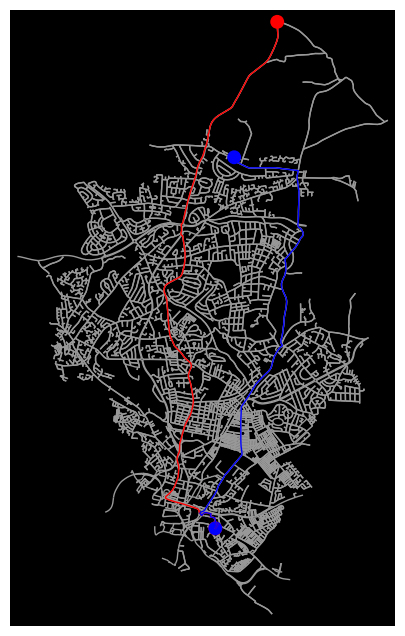

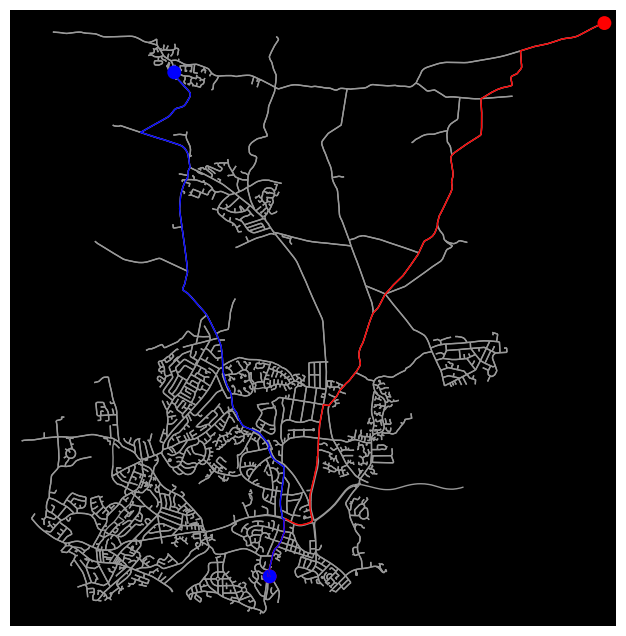

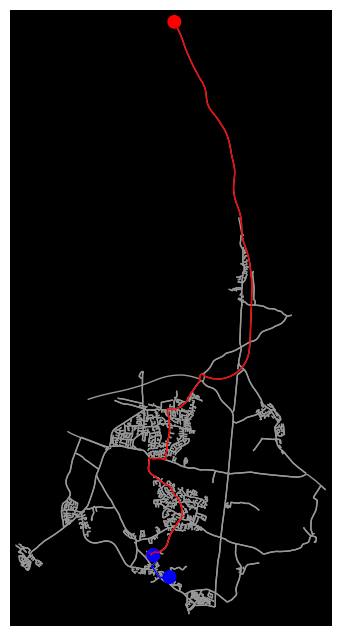

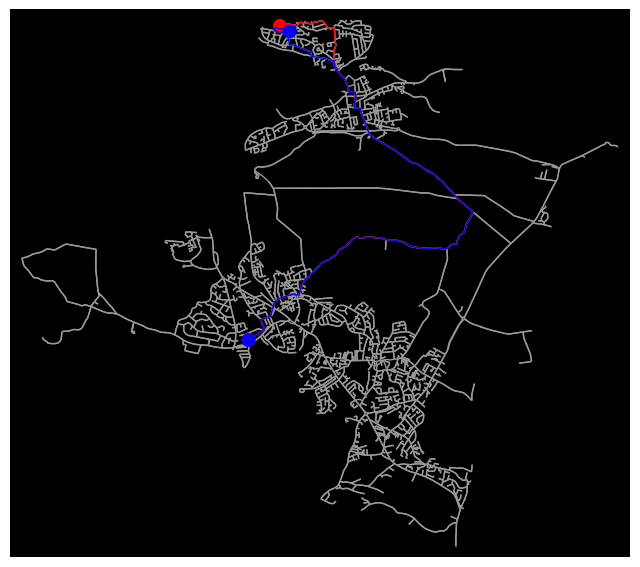

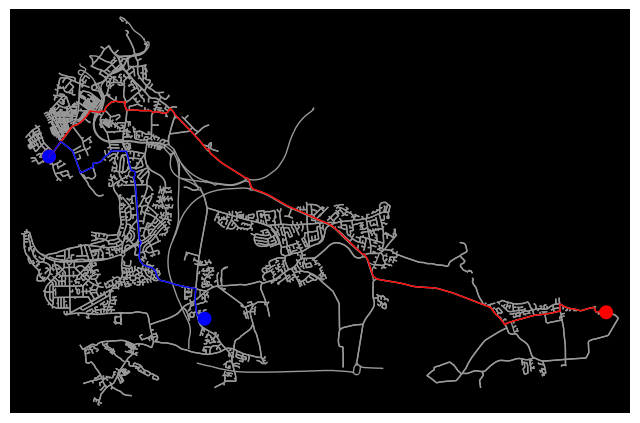

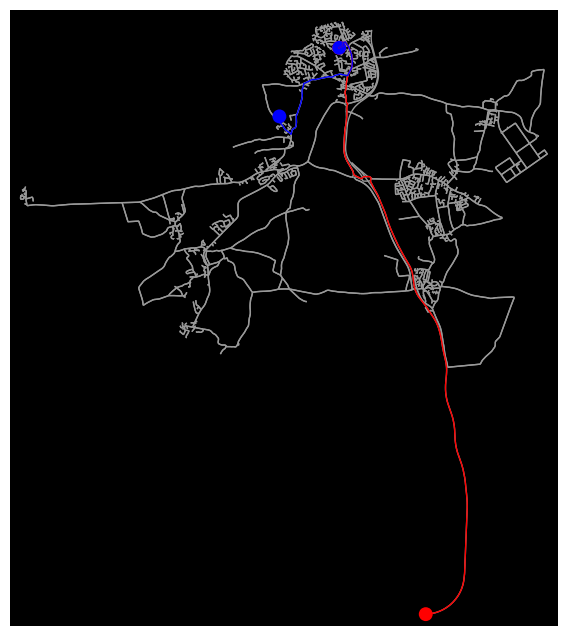

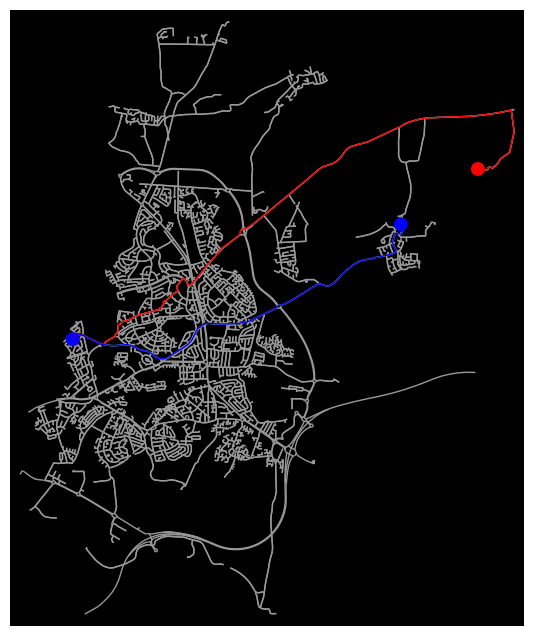

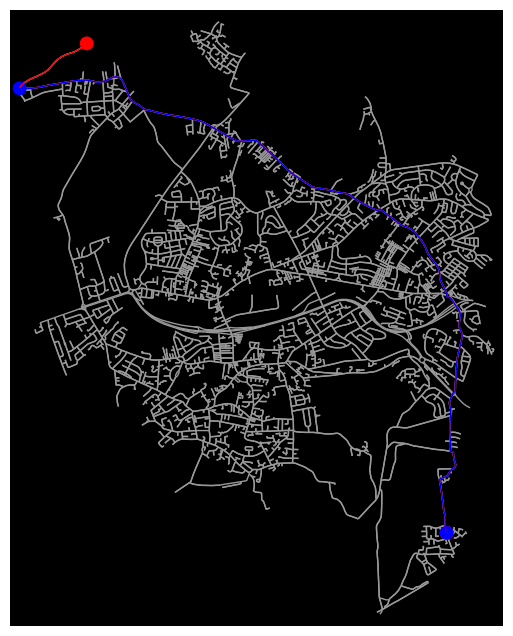

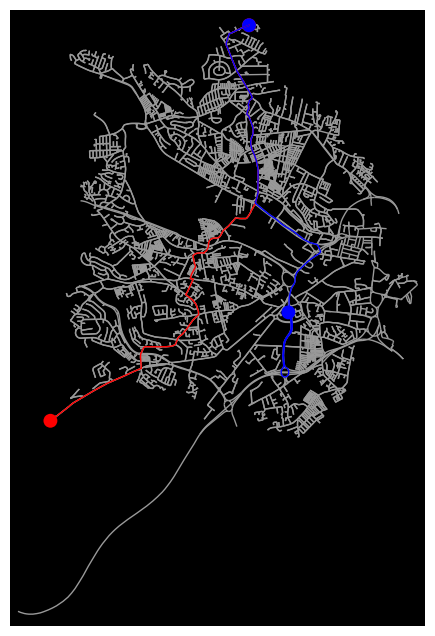

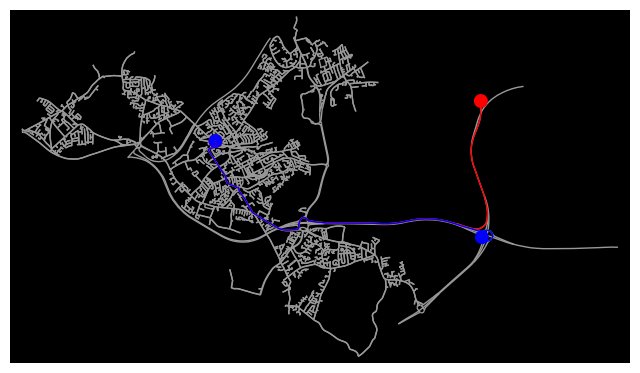

In [433]:
for line, cell_graph in zip(lines, cell_graphs):
    ox.plot_graph_routes(cell_graph, line, route_colors=['r','b'], route_linewidths=1, node_size=0, bgcolor='k', route_alpha=1)